## Deterministic Uncertainty Quantification.

When performing classification tasks it is useful to have an uncertainty score providing an understanding of the uncertainty of the model together with a prediciton. This notebook is a tensorflow implementation of the [Deterministic Uncertainty Quantification](https://proceedings.mlr.press/v119/van-amersfoort20a.html) model for the two moons dataset. The paper uses an [RBF network](https://en.wikipedia.org/wiki/Radial_basis_function_network) (from 1988) to provide  a classification and an uncertainty score. 

In an RBF network there are centroids $e_c$ wherethe distance of the centroid to $x$ is used to choose the class and the uncertainty of the prediction. Let $K_c(x)=-\exp(||W_c f(x) - e_c ||^2_2)$. Where $W_c$ is a matrix and $f$ is a neural network. Then the predicted class for $x$ is given by $\arg \max_c K_c(x)$ and the uncertainty is given by $\max_c K_c(x)$. 

In [1]:
import tensorflow as tf
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras.regularizers import l2
from sklearn.datasets import make_moons, make_blobs

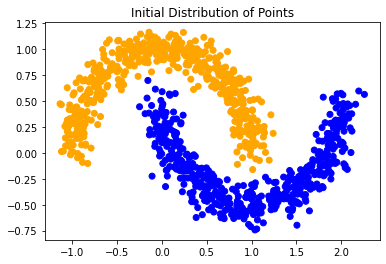

In [2]:
X,y=make_moons(1000, noise=0.1) 
plt.title('Initial Distribution of Points')
plt.scatter(X[:,0],X[:,1],c=['blue' if i else 'orange' for i in y])

The centroids are set as non trainable and are updated using the update_centroids function. This is because the model become very unstable if the centroids are updated using gradient descent. Update_centroids will find the optimum value for the centroids if $f$ and $W_c$ are fixed. The speed of convergence for update_centroids is controlled by the gamma parameter and is tunable. 

In [3]:
class DuqModel(tf.keras.Model):
    def __init__(self):
        super(DuqModel, self).__init__()
        
        self.gamma = 0.99 
        self.sigma = 0.3
        self.emb_size = 2
        self.centroid_size = 10
        feature_size = 20

        
        self.l1 = tf.keras.layers.Dense(feature_size, input_shape=(2,), activation='relu', name='l1')
        self.l2 = tf.keras.layers.Dense(feature_size, activation='relu', name='l2')
        self.l3 = tf.keras.layers.Dense(feature_size, name='l3')
        self.W = [tf.keras.layers.Dense(self.centroid_size,
                        input_shape=(feature_size,)) for i in range(self.emb_size)]

        self.N=tf.Variable( tf.ones(self.emb_size)*25,trainable=False)
        self.m=tf.Variable( tf.random.normal((self.emb_size,self.centroid_size),stddev=1),trainable=False) 

    @property
    def centroids(self):
        ret=tf.Variable(np.zeros((self.emb_size,self.centroid_size),dtype=np.float32),trainable=False)
        for i in range(self.emb_size):
            ret[i].assign(self.m[i]/self.N[i])
        return ret
    
    def embed(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

    def call(self, x):
        """
        Embeds x. Then finds the the distance from the centroids. Returns the RBF kernel of the distance
        """
        x_ms=self.embed(x)
        def inner_comp(i):
            wc,e=self.W[i],self.centroids[i]
            return tf.linalg.norm(wc(x_ms)-e, axis=1)**2
        cent_dist=tf.transpose([inner_comp(i) for i in range(self.emb_size)])
        return tf.math.exp( -cent_dist/(2*self.sigma**2) )
    
    def prediction_uncertainty(self, x):
        ret=self.call(x)
        return tf.math.reduce_max(ret, axis=1)  
    
    def prediction(self, x):
        ret=self.call(x)
        return tf.math.argmax(ret, axis=1)
    
    def pred_acc(self, y_true, x):
        y_preds=self.prediction(x)
        y_true=tf.cast(y_true, tf.float32)
        y_preds=tf.cast(y_preds, tf.float32)
        abs_diff=tf.math.abs(y_true-y_preds)
        return 1-tf.math.reduce_mean(abs_diff)
    
    def update_centroids(self, x, y):
        x_ms=self.embed(x)
        hoty = tf.one_hot(y, self.emb_size)    

        self.N = self.gamma * self.N + (1 - self.gamma) * tf.math.reduce_sum(hoty,axis=0)
        features_sum=[]
        for i in range(self.emb_size):
            features_sum.append(tf.expand_dims(hoty[:,i], 0)@self.W[i](x_ms))
        features_sum=tf.concat(features_sum, axis=0)
        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum

model=DuqModel()

2022-08-18 22:32:12.180668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    name='SGD',
)

To train the model we will use Categorical Crossentropy. There are several regularisation parameters used to help convergence which should be tracked.

In [5]:
ce_loss=tf.keras.losses.SparseCategoricalCrossentropy()

pred_acc = tf.keras.metrics.Mean(name='pred_acc')
total_loss_metric = tf.keras.metrics.Sum(name='total_loss_metric')
ce_loss_metric = tf.keras.metrics.Sum(name='ce_loss')
grad_penalty_loss = tf.keras.metrics.Sum(name='grad_penalty')
centroid_penalty_loss = tf.keras.metrics.Sum(name='centroid_penalty_loss')

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X, y)).shuffle(10000).batch(64)

This gradient penalty ensures the jacobian isn't too large or small. If the jacobian is too large the model isn't very smooth and may not generalise well. If the jacobian is too large the model may collapse inputs meaning many data points are mapped to the similar data points. This will prevent the model capturing uncertainty as the data may be a similar distance to the centroids.

In [7]:
def calc_gradient_penalty(X, y_pred, tape):
    grads=tape.gradient(y_pred, model.trainable_variables)
    ret=10**-4*abs(0.45-np.mean([tf.linalg.norm(i) for i in grads]))**1.5
    return ret

In [8]:
def train_step(X, y):
    model.update_centroids(X,y)

    with tf.GradientTape(persistent=True) as tape:
        y_pred = model(X, training=True)
        loss1 = ce_loss(y, y_pred) # cross entropy loss
        loss2 = calc_gradient_penalty(X, y_pred,tape) # gradient penalty
        loss3 = 0.0001*tf.reduce_sum([tf.linalg.norm(i) for i in model.variables if 'bias' not in i.name]) #l2 loss reg
        total_loss = loss1 + loss2 + loss3
        
    gradients = tape.gradient(total_loss, model.trainable_variables)
    del tape
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    pred_acc(model.pred_acc(y, X))
    total_loss_metric(total_loss)
    ce_loss_metric(loss1)
    grad_penalty_loss(loss2)
    centroid_penalty_loss(loss3)
    
    return gradients


In [9]:
def check_uncertainty(epoch,plot=False):
    """
    Records the uncertainty of the model at each epoch
    """
    x_linspace = np.linspace(-3, 3, 100)
    y_linspace = np.linspace(-3, 3, 100)
    xx_mesh, yy_mesh = np.meshgrid(x_linspace, y_linspace)
    meshgrid=np.array(list(zip(xx_mesh.reshape(-1), yy_mesh.reshape(-1))))
    preds=model.prediction_uncertainty(meshgrid).numpy()
    fig = plt.figure()
    cs = plt.contourf(x_linspace, y_linspace, preds.reshape(100,100),cmap='cividis')
    plt.scatter(X[:,0], X[:,1], c=['blue' if i else 'orange' for i in y], s=0.5)
    plt.title(f'Uncertainty at Epoch {epoch}')
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.savefig(f'/tmp/duq{epoch}')
    if not plot:
        plt.close(fig)
    else:
        plt.show()

In [10]:
tf.random.set_seed(11005)
np.random.seed(11005)
model = DuqModel()
EPOCHS = 30
for epoch in range(EPOCHS):
    total_loss_metric.reset_states()
    pred_acc.reset_states()
    grad_penalty_loss.reset_states()
    centroid_penalty_loss.reset_states()
    ce_loss_metric.reset_states()

    for xi, yi in train_ds:
        train_step(xi, yi)
       
    print(
    f'Epoch {epoch + 1}, '
    f'pred_acc: {pred_acc.result().numpy():.6f}, '
    f'Total Loss: {total_loss_metric.result().numpy():.9f}, '
    f'ce Loss: {ce_loss_metric.result().numpy():.9f}, '
    f'grad_loss: {grad_penalty_loss.result().numpy():.6f}, '
    f'l2_loss: {centroid_penalty_loss.result().numpy():.6f}, '
  )
    check_uncertainty(epoch, plot=False)

Epoch 1, pred_acc: 0.814258, Total Loss: 7.035872936, ce Loss: 6.478619576, grad_loss: 0.528968, l2_loss: 0.028285, 
Epoch 2, pred_acc: 0.902344, Total Loss: 5.352526188, ce Loss: 4.976190567, grad_loss: 0.348038, l2_loss: 0.028298, 
Epoch 3, pred_acc: 0.972656, Total Loss: 2.308748245, ce Loss: 2.035901546, grad_loss: 0.244477, l2_loss: 0.028369, 
Epoch 4, pred_acc: 0.991602, Total Loss: 0.765863419, ce Loss: 0.570907772, grad_loss: 0.166284, l2_loss: 0.028672, 
Epoch 5, pred_acc: 0.999023, Total Loss: 0.427820534, ce Loss: 0.234348848, grad_loss: 0.164598, l2_loss: 0.028873, 
Epoch 6, pred_acc: 0.999023, Total Loss: 0.405840307, ce Loss: 0.188178092, grad_loss: 0.188691, l2_loss: 0.028972, 
Epoch 7, pred_acc: 0.999023, Total Loss: 0.458970636, ce Loss: 0.192770928, grad_loss: 0.237162, l2_loss: 0.029038, 
Epoch 8, pred_acc: 0.998438, Total Loss: 0.509367228, ce Loss: 0.208183482, grad_loss: 0.272104, l2_loss: 0.029080, 
Epoch 9, pred_acc: 0.997070, Total Loss: 0.545360386, ce Loss: 0

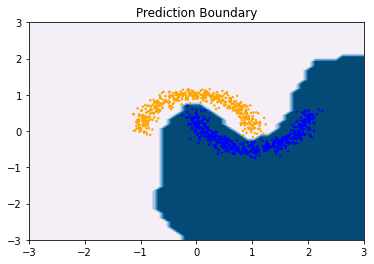

In [11]:
def check_predictions():
    x_linspace = np.linspace(-3, 3, 50)
    y_linspace = np.linspace(-3, 3, 50)
    xx_mesh, yy_mesh = np.meshgrid(x_linspace, y_linspace)
    meshgrid=np.array(list(zip(xx_mesh.reshape(-1), yy_mesh.reshape(-1))))
    preds=model.prediction(meshgrid).numpy()
    cs = plt.contourf(x_linspace, y_linspace, preds.reshape(50,50), cmap=cm.PuBu)
    plt.scatter(X[:,0], X[:,1], c=['blue' if i else 'orange' for i in y],s=2)
    plt.title('Prediction Boundary')
    plt.show()
check_predictions()

The pink and blue in this diagram shows the prediction boundary of the network. It has correctly learnt a boundary that will classify the points into the correct classes.

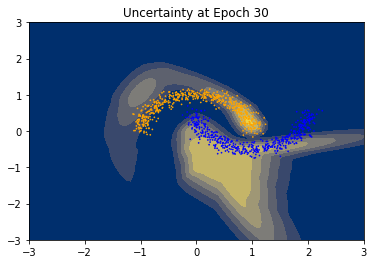

In [12]:
check_uncertainty(30, plot=True)

This diagram shows the uncertainty at different epochs. Yellow indicateds certainty whereas blue represents uncertainty. The model has come close to getting the correct uncertainty but it's not perfect. The final output of the model depends a lot on the hyperparameters and the weight initialization.

In [13]:
import imageio
with imageio.get_writer('uncertainty_prog.gif', mode='I') as writer:
    for filename in [f'/tmp/duq{i}.png' for i in range(0,30)]:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

![Progression of uncertainty](uncertainty_prog.gif)

This animation shows how the uncertainty boundary changes during training.